# 3_EDA: Price Predictor

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Read file cleaned in DW
supply_chain_df_cleaned = pd.read_csv('../../data/price_predictor/staged/Sample_Product_Data_Cleaned.csv')

---

### Basic data exploration

In [4]:
# Data glance
supply_chain_df_cleaned.head()

,product_type,sku,price,availability,number_of_products_sold,revenue_generated,customer_demographics,stock_levels,lead_times,order_quantities,...,location,lead_time,production_volumes,manufacturing_lead_time,manufacturing_costs,inspection_results,defect_rates,transportation_modes,routes,costs
0,cosmetics,062000007,22.79,17.0,715.0,8656.12,Non-binary,58.0,24.0,79.0,...,Kolkata,16.0,168.0,21.0,71.42,Pending,3.35,Rail,Route_B,407.65
1,cosmetics,1VBA0260GE,53.97,78.0,949.0,4516.14,Unknown,75.0,15.0,90.0,...,Delhi,3.0,617.0,28.0,80.63,Pass,4.66,Rail,Route_A,424.80
2,skincare,1VBF0810GE,80.18,44.0,687.0,6449.54,Male,97.0,20.0,10.0,...,Delhi,13.0,306.0,17.0,65.34,Pending,0.61,Air,Route_B,603.41
3,skincare,1VMG0080GE,62.87,46.0,903.0,1755.28,Female,18.0,21.0,98.0,...,Delhi,20.0,486.0,29.0,29.09,Fail,3.09,Rail,Route_C,331.07
4,skincare,1VMG0140GE,83.82,99.0,163.0,7097.87,Non-binary,88.0,18.0,50.0,...,Chennai,23.0,941.0,17.0,97.18,Pending,2.58,Road,Route_B,392.25


In [5]:
# Dataset info
supply_chain_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790 entries, 0 to 1789
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_type             1790 non-null   object 
 1   sku                      1790 non-null   object 
 2   price                    1790 non-null   float64
 3   availability             1790 non-null   float64
 4   number_of_products_sold  1790 non-null   float64
 5   revenue_generated        1790 non-null   float64
 6   customer_demographics    1790 non-null   object 
 7   stock_levels             1790 non-null   float64
 8   lead_times               1790 non-null   float64
 9   order_quantities         1790 non-null   float64
 10  shipping_times           1790 non-null   float64
 11  shipping_carriers        1790 non-null   object 
 12  shipping_costs           1790 non-null   float64
 13  supplier_name            1790 non-null   object 
 14  location                

---

### Dataset description

In [6]:
# Dataset info
supply_chain_df_cleaned.describe()

,price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,production_volumes,manufacturing_lead_time,manufacturing_costs,defect_rates,costs
count,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000
mean,50.966804,50.641341,508.297765,5594.913486,49.981006,14.745810,49.790503,5.062011,5.497246,14.970950,537.507821,15.179330,55.422536,2.508626,550.428497
std,28.349810,28.572735,285.985693,2569.747229,28.676248,8.347382,28.090631,2.561280,2.557734,8.296305,259.669904,8.213523,25.849102,1.438392,257.798706
min,1.010000,1.000000,1.000000,1016.190000,1.000000,1.000000,1.000000,1.000000,1.010000,1.000000,100.000000,1.000000,10.000000,0.000000,100.770000
25%,26.040000,26.000000,263.000000,3403.432500,25.000000,7.000000,26.000000,3.000000,3.260000,8.000000,317.500000,8.000000,33.065000,1.290000,324.517500
50%,51.370000,51.000000,516.000000,5640.640000,51.000000,15.000000,50.000000,5.000000,5.430000,15.000000,534.500000,15.000000,55.855000,2.500000,557.175000
75%,75.395000,75.000000,756.000000,7758.960000,75.000000,22.000000,75.000000,7.000000,7.680000,22.000000,763.000000,22.000000,77.797500,3.777500,766.612500
max,99.990000,99.000000,999.000000,9994.800000,99.000000,29.000000,99.000000,9.000000,10.000000,29.000000,999.000000,29.000000,99.880000,5.000000,998.960000


| **Variable Name**          | **Description**                                    | **Type of Data** |
|----------------------------|----------------------------------------------------|------------------|
| Product type               | Type of product                                    | Object           |
| SKU                        | Stock Keeping Unit                                 | Object           |
| Price                      | Price of the product                               | Float            |
| Availability               | Availability status of the product                 | Float            |
| Number of products sold    | Number of products sold                            | Float            |
| Revenue generated          | Total revenue generated                            | Float            |
| Customer demographics      | Demographic details of the customers               | Object           |
| Stock levels               | Current stock levels                               | Float            |
| Lead times                 | Time taken from order to delivery                  | Float            |
| Order quantities           | Quantities ordered                                 | Float            |
| Shipping times             | Time taken for shipping                            | Float            |
| Shipping carriers          | Carriers used for shipping                         | Object           |
| Shipping costs             | Cost incurred for shipping                         | Float            |
| Supplier name              | Name of the supplier                               | Object           |
| Location                   | Location of the supplier                           | Object           |
| Lead time                  | Time taken by supplier to fulfill orders           | Float            |
| Production volumes         | Volume of products produced                        | Float            |
| Manufacturing lead time    | Time taken for manufacturing                       | Float            |
| Manufacturing costs        | Costs involved in manufacturing                    | Float            |
| Inspection results         | Results from product inspections                   | Object           |
| Defect rates               | Rates of defects found in products                 | Float            |
| Transportation modes       | Modes of transportation used                       | Object           |
| Routes                     | Routes used for transportation                     | Object           |
| Costs                      | Overall costs                                      | Float            |


In [7]:
# Dataframe for variable analysis
supply_chain_eda_df = supply_chain_df_cleaned.copy()

---

### Univariate Analysis

In the following section, we will do an analysis per each variable to analyze their distribution, values and other statistical data we can obtain by this analysis.

**Numerical columns** : [

    'Price',
    'Availability',
    'Number of products sold',
    'Revenue generated',
    'Stock levels',
    'Lead times',
    'Order quantities',
    'Shipping times',
    'Shipping costs',
    'Lead time',
    'Production volumes',
    'Manufacturing lead time',
    'Manufacturing costs',
    'Defect rates',
    'Costs'
    
]

---

`Price`

In [8]:
supply_chain_eda_df['price'].describe()

count    1790.000000
mean       50.966804
std        28.349810
min         1.010000
25%        26.040000
50%        51.370000
75%        75.395000
max        99.990000
Name: price, dtype: float64

- **Mean (Average Price):** The average price is approximately 50.97 units, indicating that products are moderately priced around this central value.
- **Standard Deviation (Variability):** The standard deviation is 28.35 units, showing significant variability in product prices.
- **Minimum Price:** The lowest price is 1.01 units, suggesting the presence of budget-friendly options within the product range.
- **25th Percentile (Q1):** 25% of products are priced at 26.04 units or less, highlighting that a significant portion of products are relatively low-priced.
- **Median (50th Percentile):** The median price is 51.37 units, meaning half the products are priced below and half above this value, indicating a relatively symmetric price distribution.
- **75th Percentile (Q3):** 75% of products are priced at 75.40 units or less, showing that most products fall below this price, with only a quarter being more expensive.

In [9]:
print(f'Number of unique values: {len(supply_chain_eda_df["price"].unique())}')
print(supply_chain_eda_df["price"].unique())

Number of unique values: 1636
[22.79 53.97 80.18 ... 89.58 27.12 64.56]


In [10]:
# Setting style for plots
sns.set_theme(style="whitegrid")

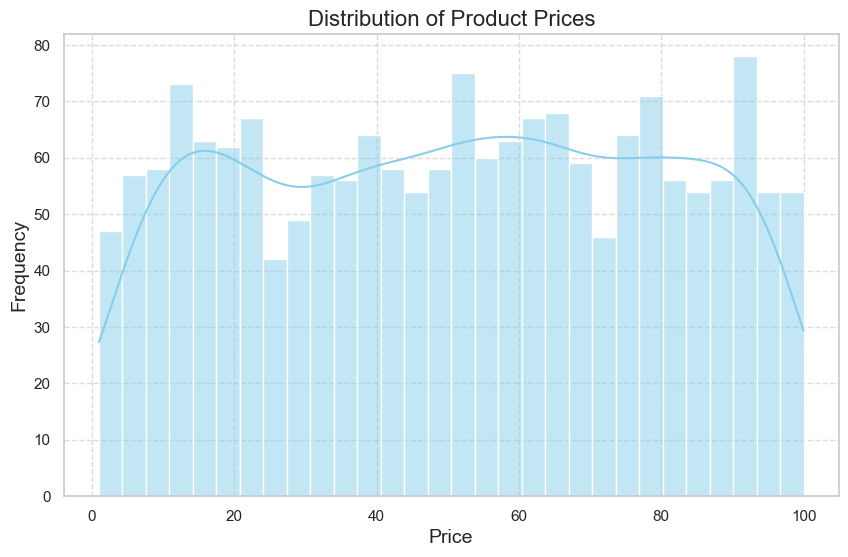

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['price'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Product Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

- The distribution of product prices is bimodal, with peaks around 10-20 dollars and 50-60 dollars.
- Prices significantly taper off after 60 dollars, suggesting fewer higher-priced products.
- The range between 20 and 45 dollars shows a noticeable dip in product frequency.
- A slight uptick in frequency occurs near the 100 dollar mark.
- Most products are priced under 60 dollars, highlighting a concentration of more affordable options in the dataset.

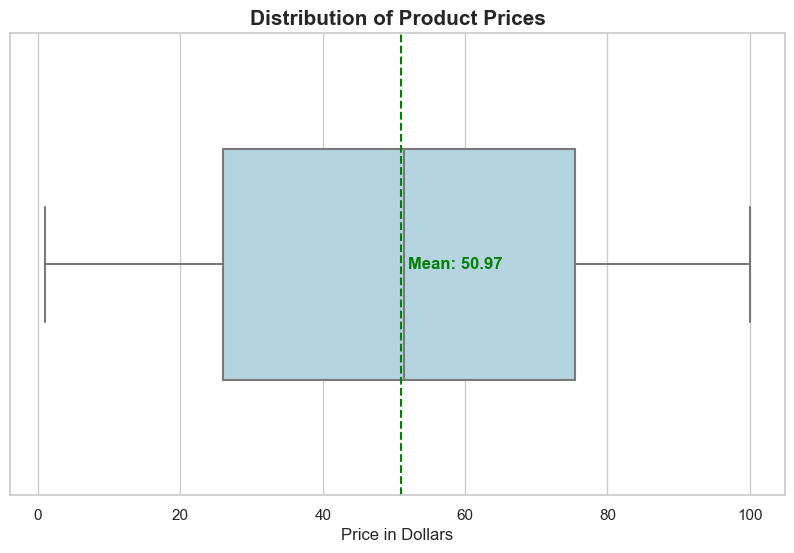

In [12]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['price'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Product Prices', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Price in Dollars', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['price'].mean()
plt.axvline(mean_price, color='green', linestyle='--') 
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

# Show the plot
plt.show()

- The mean price of the products is approximately 50.97 dollars.
- Prices are symmetrically distributed around the mean.
- Prices range from near 0 to almost 100 dollars.
- The middle 50% of prices (Interquartile Range) spans from about 25 to 75 dollars.
- There are no outliers in the data.
- The lowest prices are close to 0 dollars, and the highest prices approach 100 dollars.

---

`availability`

In [13]:
supply_chain_eda_df['availability'].describe()

count    1790.000000
mean       50.641341
std        28.572735
min         1.000000
25%        26.000000
50%        51.000000
75%        75.000000
max        99.000000
Name: availability, dtype: float64

- The average availability is approximately 50.64 units.
- Availability varies widely, with a standard deviation of 28.57 units.
- The minimum availability recorded is 1 unit.
- 25% of the data points have availability less than or equal to 26 units.
- The median availability is 51 units, indicating that half of the products have availability less than or equal to this value.
- 75% of the data points have availability less than or equal to 75 units.
- The maximum availability recorded is 99 units.

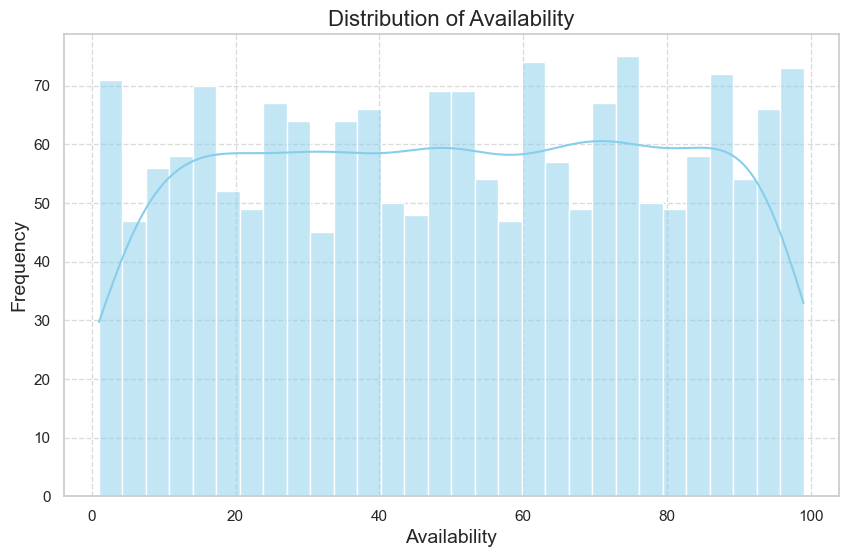

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['availability'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Availability', fontsize=16)
plt.xlabel('Availability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

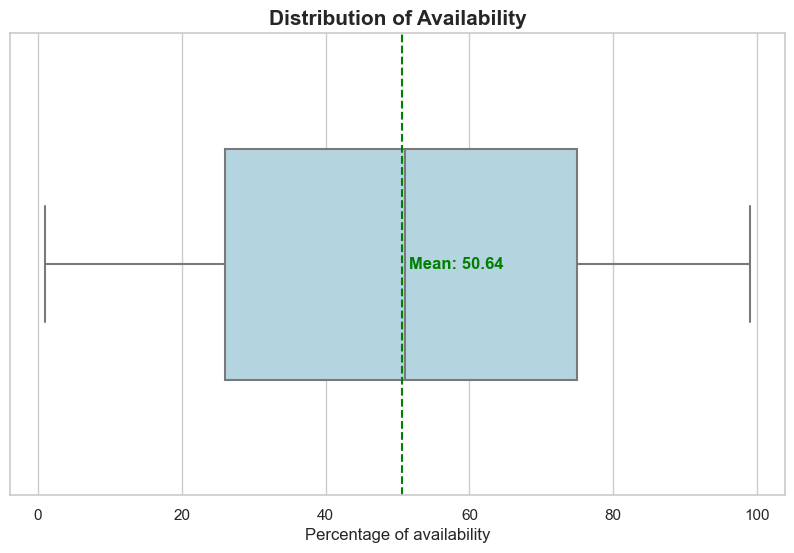

In [15]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['availability'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Availability', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Percentage of availability', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['availability'].mean()
plt.axvline(mean_price, color='green', linestyle='--') 
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Number of products sold`

In [16]:
supply_chain_eda_df['number_of_products_sold'].describe()

count    1790.000000
mean      508.297765
std       285.985693
min         1.000000
25%       263.000000
50%       516.000000
75%       756.000000
max       999.000000
Name: number_of_products_sold, dtype: float64

- The average number of products sold is approximately 508.30 units.
- There is high variability in the number of products sold, with a standard deviation of about 285.99 units.
- The minimum number of products sold is 1 unit.
- 25% of the products have sold 263 units or fewer.
- The median number of products sold is 516 units, meaning half of the products sold fewer than this number.
- 75% of the products have sold 756 units or fewer.
- The maximum number of products sold is 999 units.

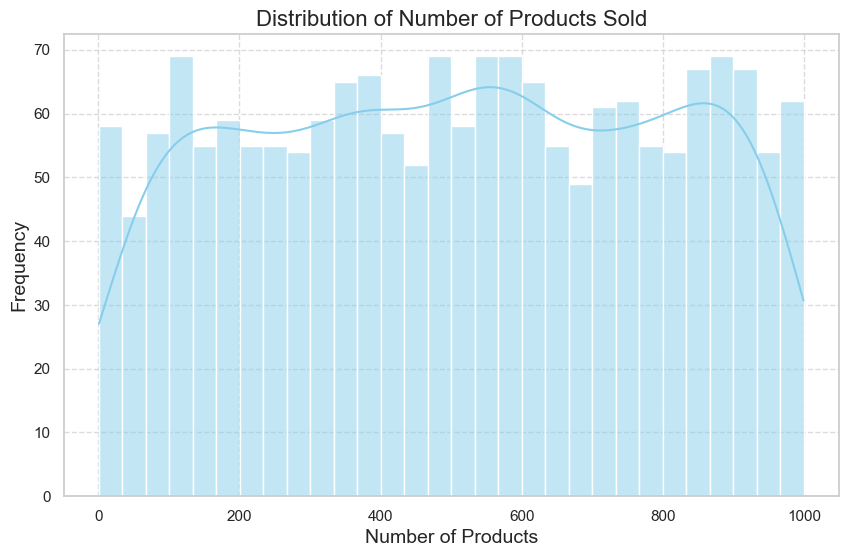

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['number_of_products_sold'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Number of Products Sold', fontsize=16)
plt.xlabel('Number of Products', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

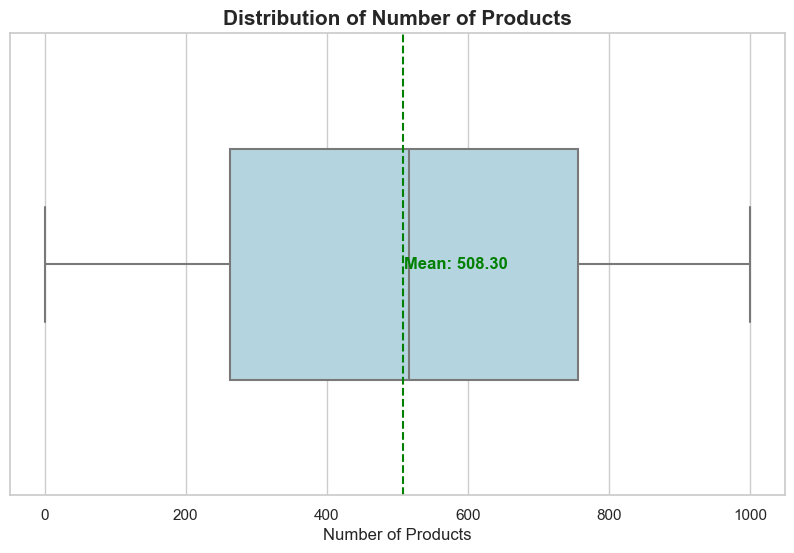

In [18]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['number_of_products_sold'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Number of Products', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Products', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['number_of_products_sold'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Revenue generated`

In [19]:
supply_chain_eda_df['revenue_generated'].describe()

count    1790.000000
mean     5594.913486
std      2569.747229
min      1016.190000
25%      3403.432500
50%      5640.640000
75%      7758.960000
max      9994.800000
Name: revenue_generated, dtype: float64

- The average revenue generated is approximately 5594.91 dollars.
- There is substantial variability in revenue, with a standard deviation of about 2569.75 dollars.
- The minimum revenue generated is 1016.19 dollars.
- 25% of the products generate revenue of 3403.43 dollars or less.
- The median revenue generated is 5640.64 dollars, indicating half of the products generate less than this amount.
- 75% of the products generate revenue of 7758.96 dollars or less.
- The maximum revenue generated is 9994.80 dollars.

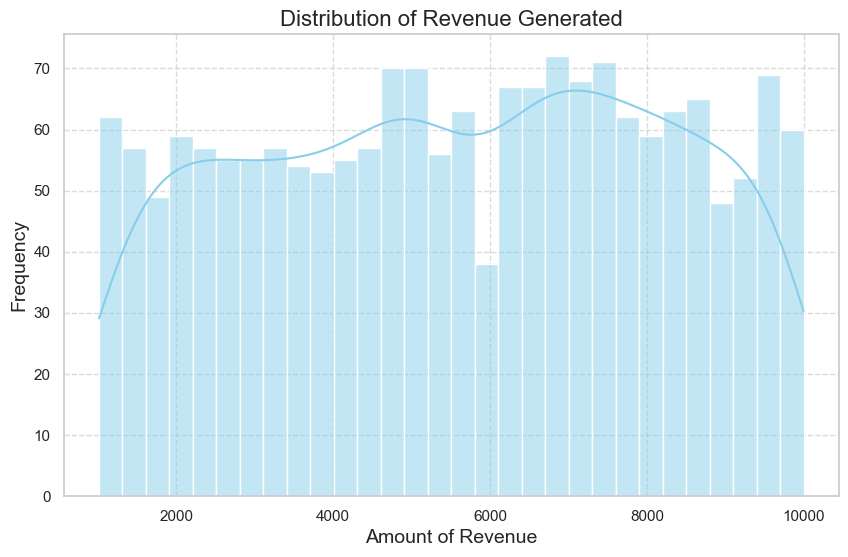

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['revenue_generated'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Revenue Generated', fontsize=16)
plt.xlabel('Amount of Revenue', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

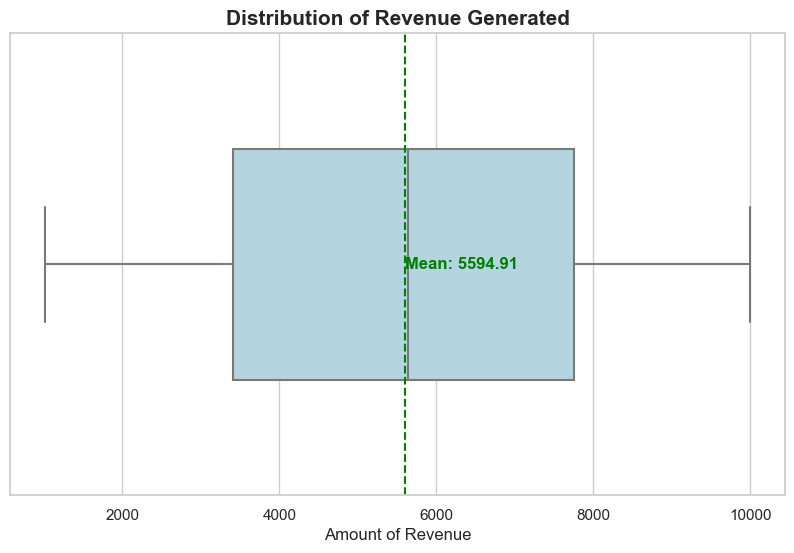

In [21]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['revenue_generated'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Revenue Generated', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Revenue', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['revenue_generated'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Stock levels`

In [22]:
supply_chain_eda_df['stock_levels'].describe()

count    1790.000000
mean       49.981006
std        28.676248
min         1.000000
25%        25.000000
50%        51.000000
75%        75.000000
max        99.000000
Name: stock_levels, dtype: float64

- The average stock level is approximately 49.98 units.
- Stock levels show high variability with a standard deviation of 28.68 units.
- The minimum stock level recorded is 1 unit.
- 25% of the products have stock levels of 25 units or less.
- The median stock level is 51 units, meaning half of the products have stock levels less than this amount.
- 75% of the products have stock levels of 75 units or less.
- The maximum stock level recorded is 99 units.

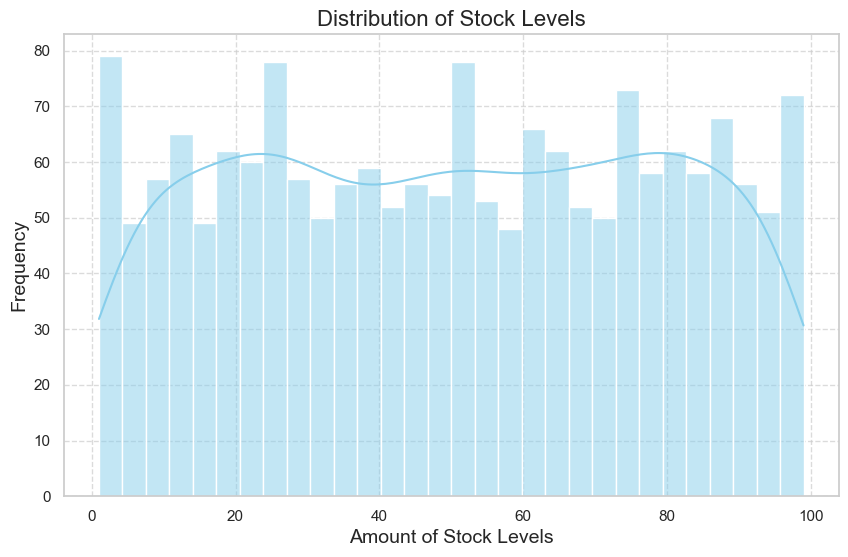

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['stock_levels'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Stock Levels', fontsize=16)
plt.xlabel('Amount of Stock Levels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

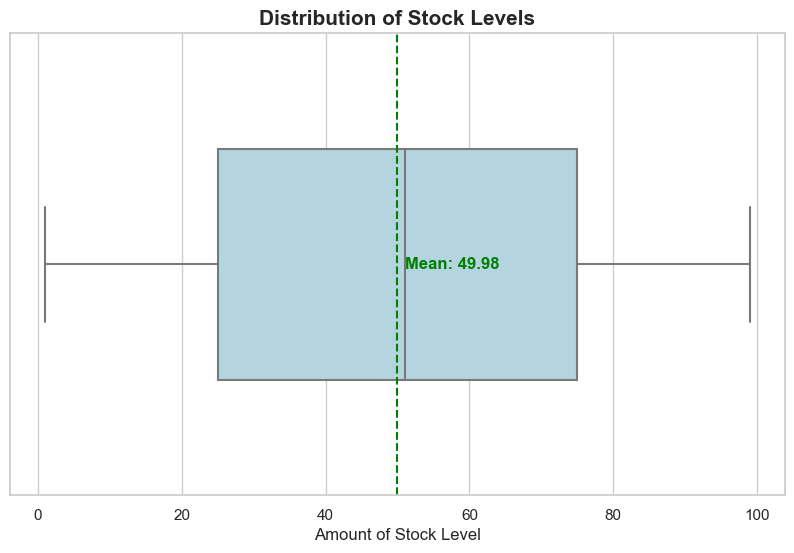

In [24]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['stock_levels'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Stock Levels', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Stock Level', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['stock_levels'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Lead times`

In [25]:
supply_chain_eda_df['lead_times'].describe()

count    1790.000000
mean       14.745810
std         8.347382
min         1.000000
25%         7.000000
50%        15.000000
75%        22.000000
max        29.000000
Name: lead_times, dtype: float64

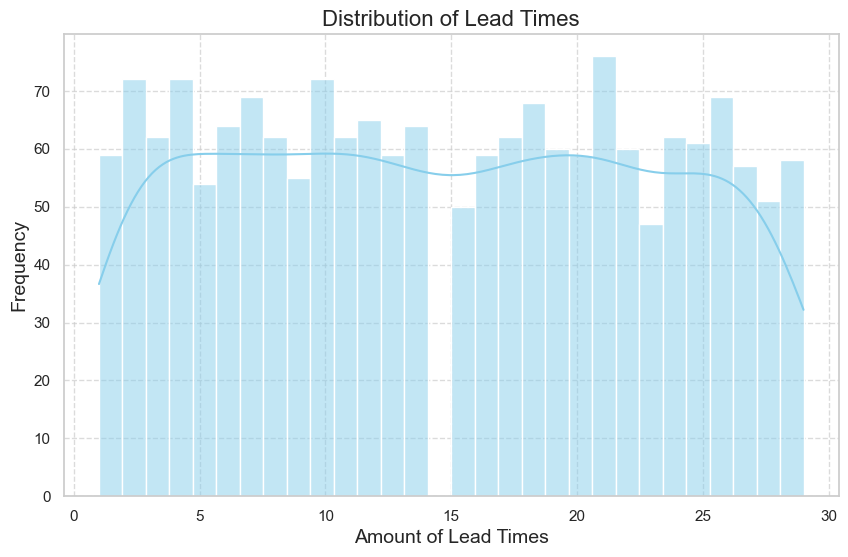

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['lead_times'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Lead Times', fontsize=16)
plt.xlabel('Amount of Lead Times', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

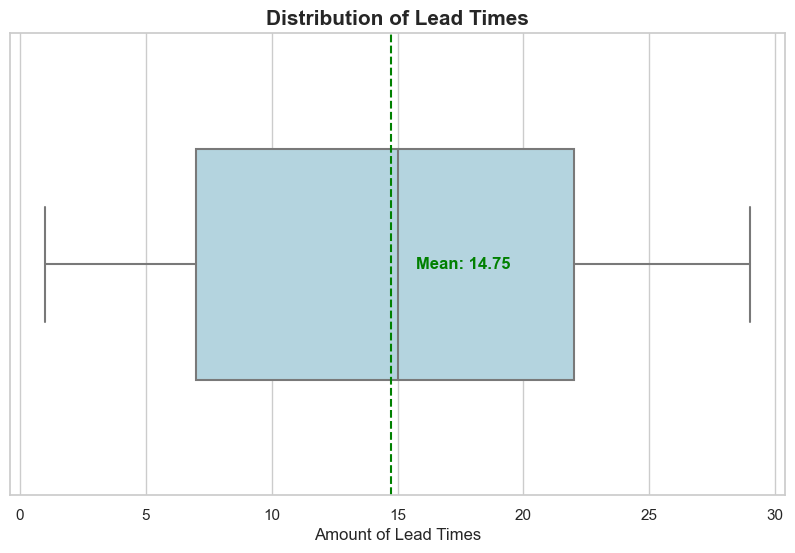

In [27]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['lead_times'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Lead Times', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Lead Times', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['lead_times'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Order quantities`

In [28]:
supply_chain_eda_df['order_quantities'].describe()

count    1790.000000
mean       49.790503
std        28.090631
min         1.000000
25%        26.000000
50%        50.000000
75%        75.000000
max        99.000000
Name: order_quantities, dtype: float64

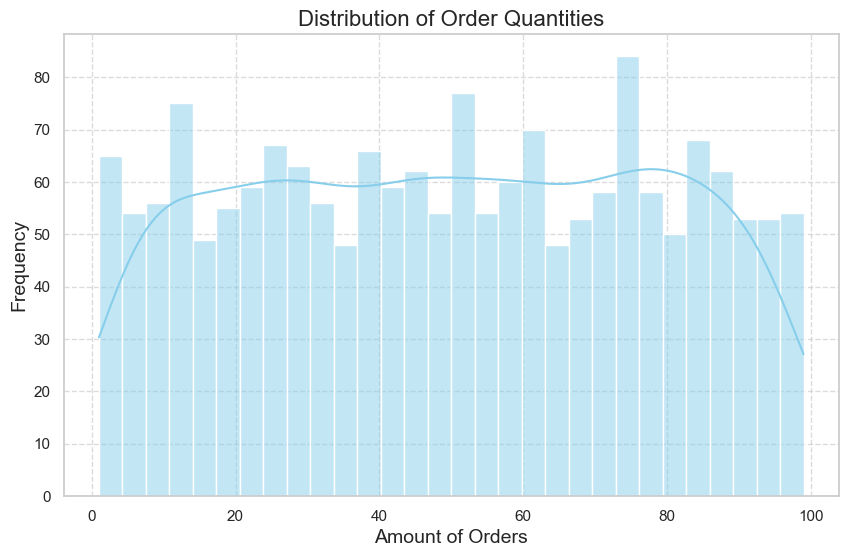

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['order_quantities'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Order Quantities', fontsize=16)
plt.xlabel('Amount of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

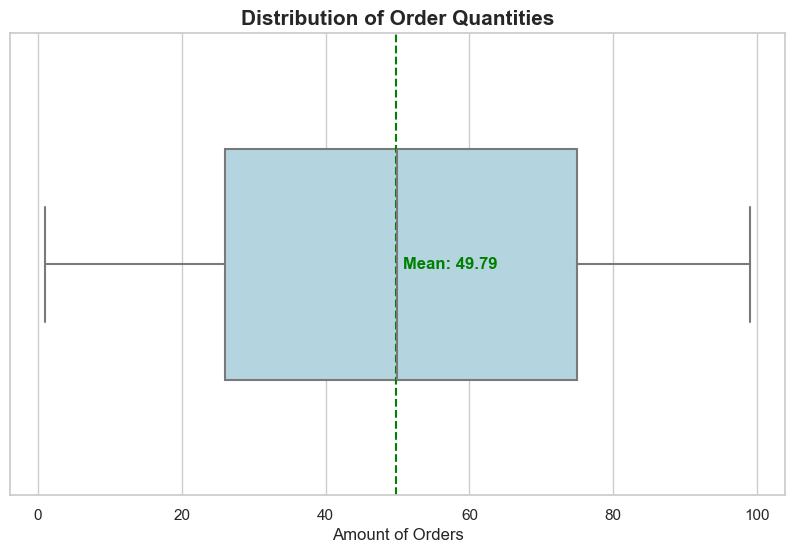

In [30]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['order_quantities'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Order Quantities', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Orders', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['order_quantities'].mean()
plt.axvline(mean_price, color='green', linestyle='--')  
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Shipping times`

In [31]:
supply_chain_eda_df['shipping_times'].describe()

count    1790.000000
mean        5.062011
std         2.561280
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max         9.000000
Name: shipping_times, dtype: float64

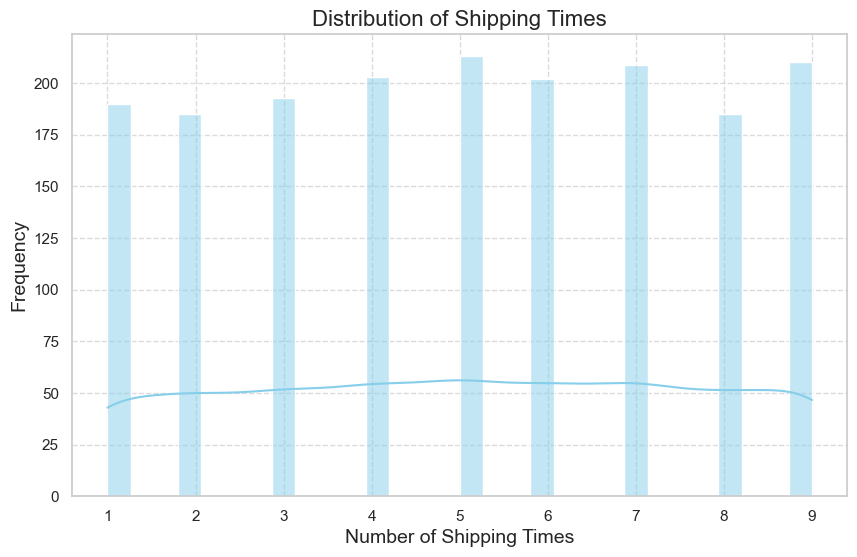

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['shipping_times'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Shipping Times', fontsize=16)
plt.xlabel('Number of Shipping Times', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

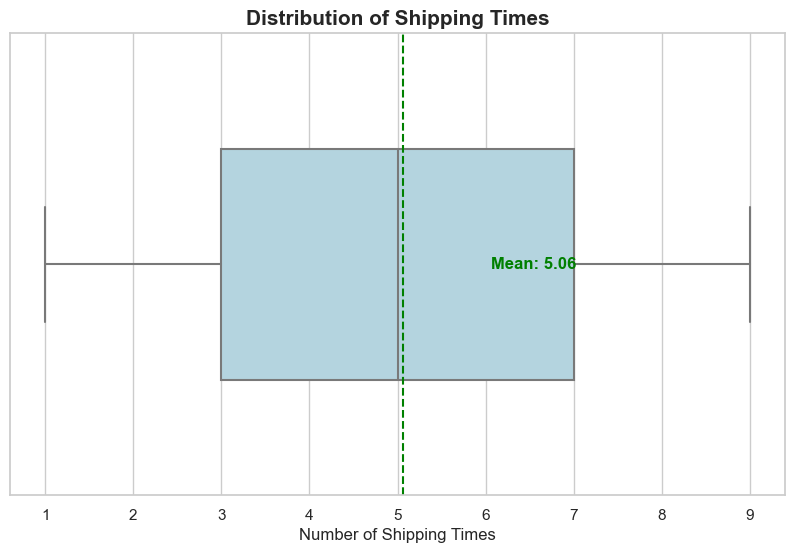

In [33]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['shipping_times'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Shipping Times', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Shipping Times', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['shipping_times'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Production volumes`

In [34]:
supply_chain_eda_df['production_volumes'].describe()

count    1790.000000
mean      537.507821
std       259.669904
min       100.000000
25%       317.500000
50%       534.500000
75%       763.000000
max       999.000000
Name: production_volumes, dtype: float64

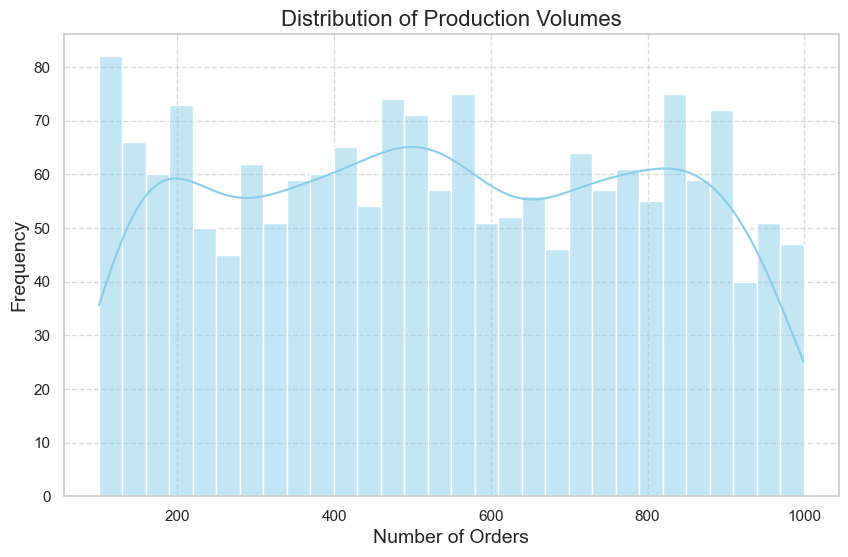

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['production_volumes'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Production Volumes', fontsize=16)
plt.xlabel('Number of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

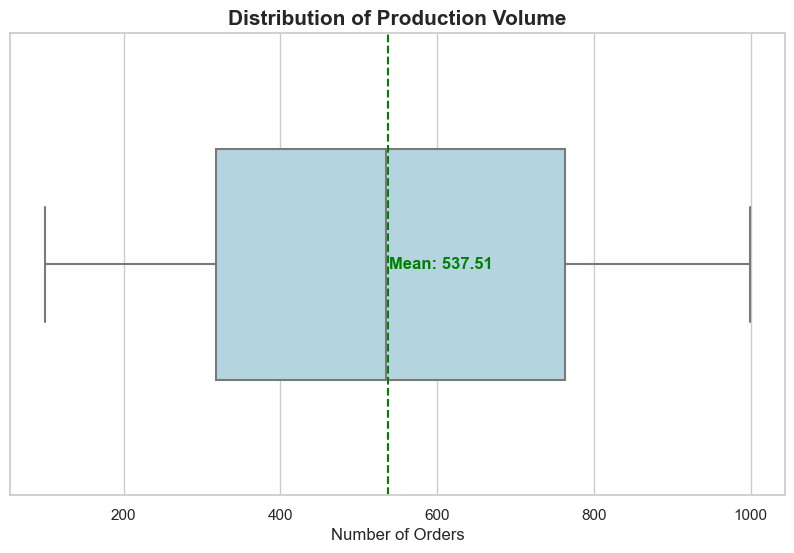

In [36]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['production_volumes'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Production Volume', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Orders', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['production_volumes'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Manufacturing lead time`

In [37]:
supply_chain_eda_df['manufacturing_lead_time'].describe()

count    1790.000000
mean       15.179330
std         8.213523
min         1.000000
25%         8.000000
50%        15.000000
75%        22.000000
max        29.000000
Name: manufacturing_lead_time, dtype: float64

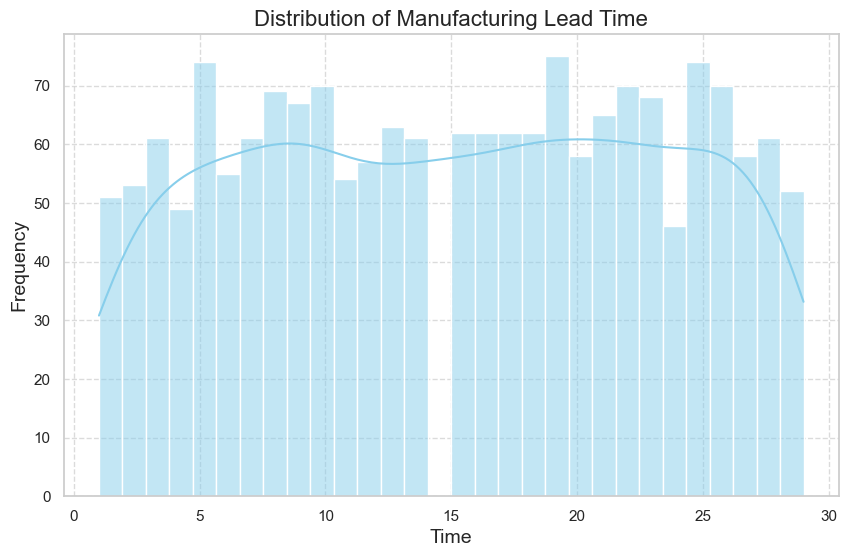

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['manufacturing_lead_time'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Manufacturing Lead Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

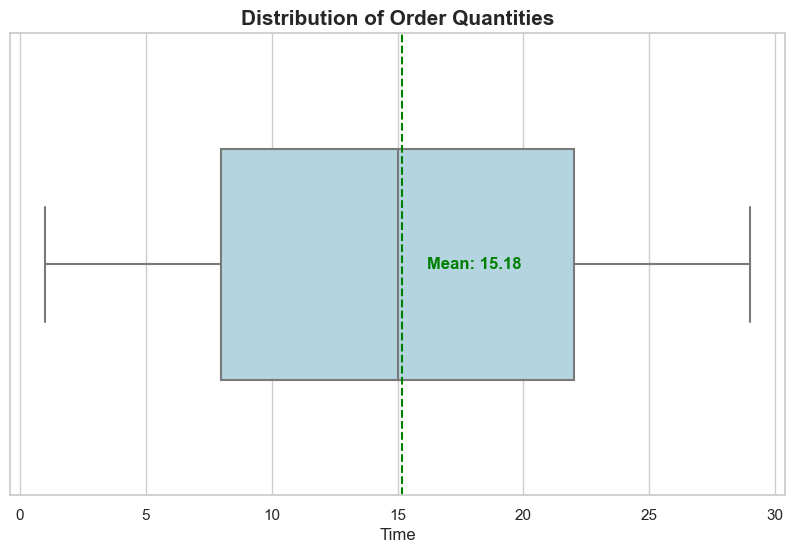

In [39]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['manufacturing_lead_time'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Order Quantities', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Time', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['manufacturing_lead_time'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Manufacturing costs`

In [40]:
supply_chain_eda_df['manufacturing_costs'].describe()

count    1790.000000
mean       55.422536
std        25.849102
min        10.000000
25%        33.065000
50%        55.855000
75%        77.797500
max        99.880000
Name: manufacturing_costs, dtype: float64

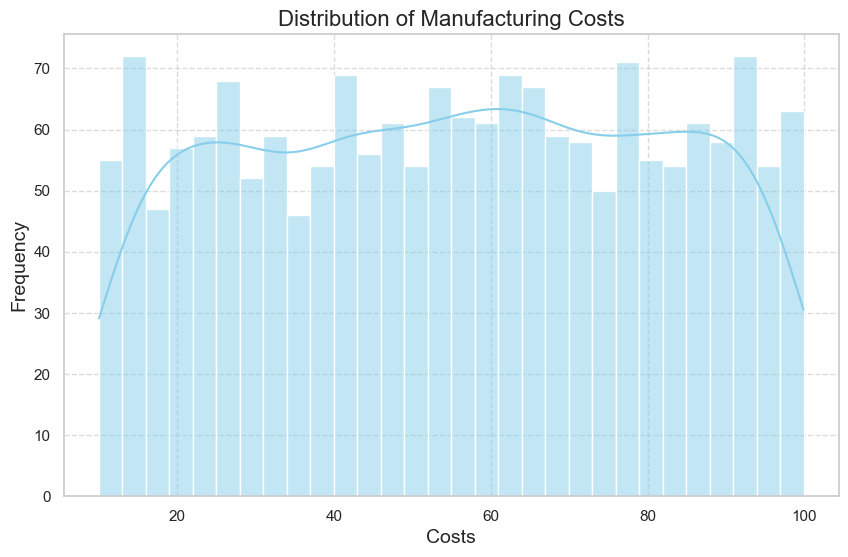

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['manufacturing_costs'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Manufacturing Costs', fontsize=16)
plt.xlabel('Costs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

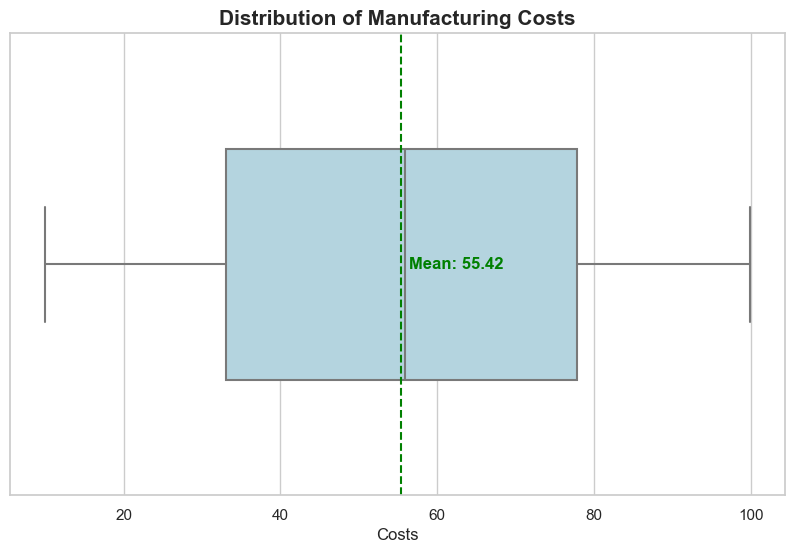

In [42]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['manufacturing_costs'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Manufacturing Costs', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Costs', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['manufacturing_costs'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Defect rates`

In [43]:
supply_chain_eda_df['defect_rates'].describe()

count    1790.000000
mean        2.508626
std         1.438392
min         0.000000
25%         1.290000
50%         2.500000
75%         3.777500
max         5.000000
Name: defect_rates, dtype: float64

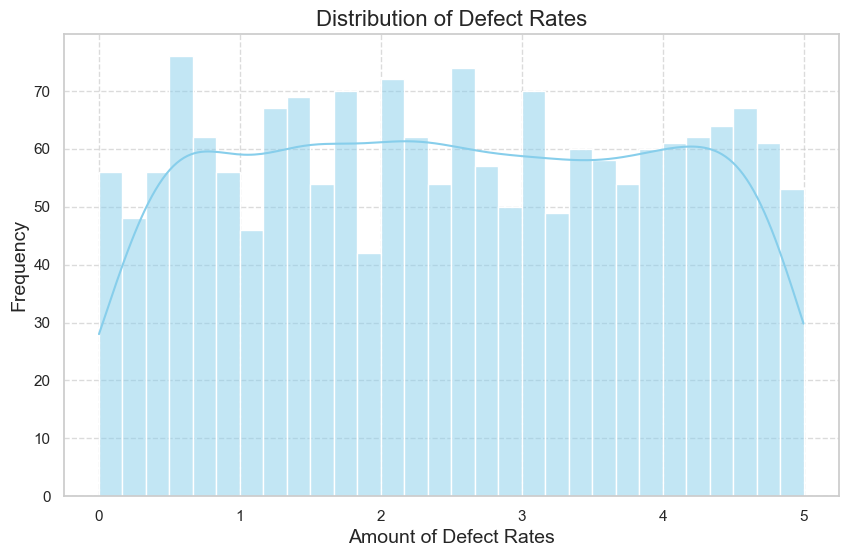

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['defect_rates'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Defect Rates', fontsize=16)
plt.xlabel('Amount of Defect Rates', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

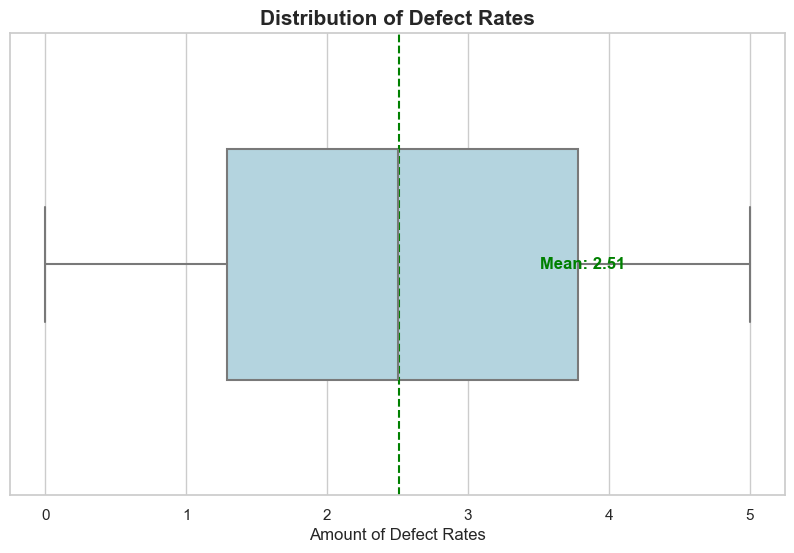

In [45]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['defect_rates'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Defect Rates', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Defect Rates', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['defect_rates'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Costs`

In [46]:
supply_chain_eda_df['costs'].describe()

count    1790.000000
mean      550.428497
std       257.798706
min       100.770000
25%       324.517500
50%       557.175000
75%       766.612500
max       998.960000
Name: costs, dtype: float64

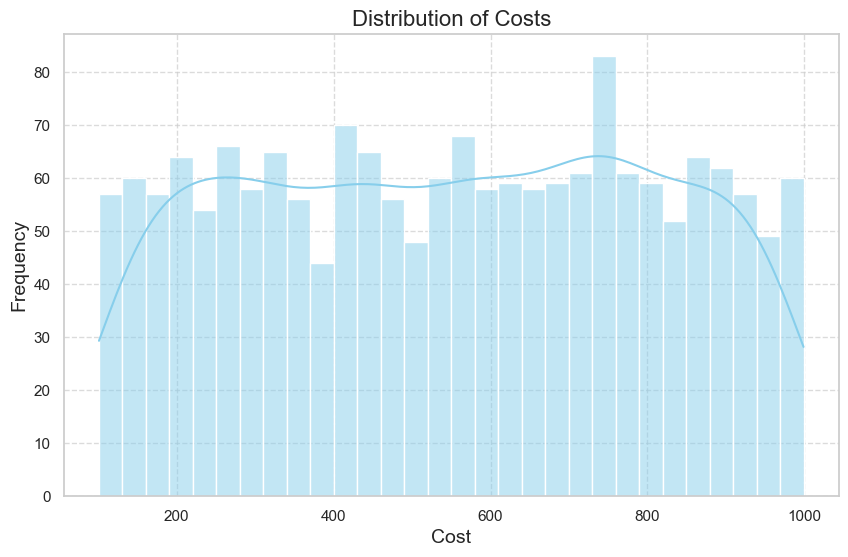

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['costs'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Costs', fontsize=16)
plt.xlabel('Cost', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

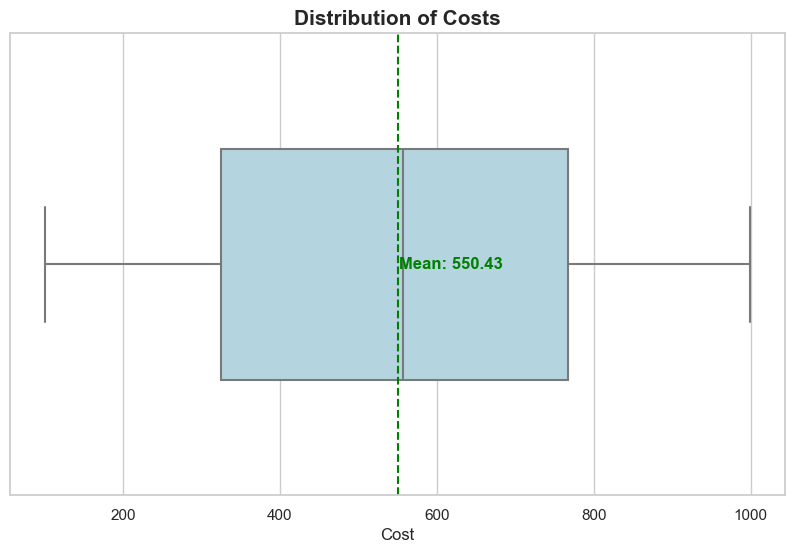

In [48]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['costs'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Costs', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Cost', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['costs'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

**Categorical columns:** [
    
    'Product type',
    'SKU',
    'Customer demographics',
    'Shipping carriers',
    'Supplier name',
    'Location',
    'Inspection results',
    'Transportation modes',
    'Routes'
]

---

`Product Type`

In [49]:
unique_values_counts = supply_chain_eda_df['product_type'].value_counts()
print(unique_values_counts)

product_type
haircare     614
skincare     600
cosmetics    576
Name: count, dtype: int64


  Product Type  Frequency
0     haircare        614
1     skincare        600
2    cosmetics        576


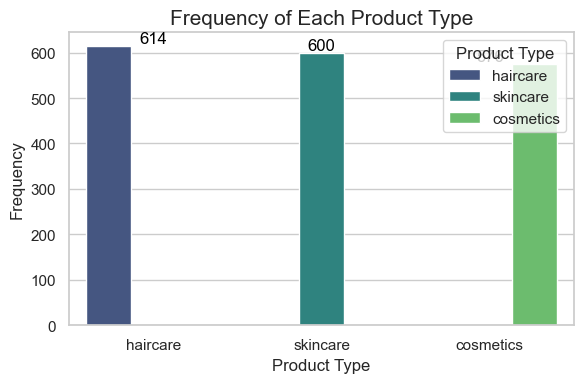

In [50]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Product Type', 'Frequency']

print(unique_values_counts_df)

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='Product Type', y='Frequency',hue='Product Type', data=unique_values_counts_df,palette='viridis')

barplot.set_title('Frequency of Each Product Type', fontsize=15)
barplot.set_xlabel('Product Type', fontsize=12)
barplot.set_ylabel('Frequency', fontsize=12)

for index, row in unique_values_counts_df.iterrows():
    barplot.text(row.name, row.Frequency, row.Frequency, color='black', ha="center", va="bottom")

plt.tight_layout()
plt.show()

---

`SKU`

In [51]:
unique_values_counts = supply_chain_eda_df['sku'].value_counts()
print(unique_values_counts)

sku
062000007          1
GN517100           1
WE107149           1
RC043500           1
LM444300           1
                  ..
C643558-0000/10    1
C646404-0692/5Q    1
C646474-4137/G5    1
C646474-6507/G5    1
CHNI013            1
Name: count, Length: 1790, dtype: int64


In [52]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['SKU', 'Frequency']

print(unique_values_counts_df)

                  SKU  Frequency
0           062000007          1
1            GN517100          1
2            WE107149          1
3            RC043500          1
4            LM444300          1
...               ...        ...
1785  C643558-0000/10          1
1786  C646404-0692/5Q          1
1787  C646474-4137/G5          1
1788  C646474-6507/G5          1
1789          CHNI013          1

[1790 rows x 2 columns]


---

`Customer Demographics`

In [53]:
unique_values_counts = supply_chain_eda_df['customer_demographics'].value_counts()
print(unique_values_counts)

customer_demographics
Male          511
Unknown       446
Non-binary    438
Female        395
Name: count, dtype: int64


In [54]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Customer Demographics', 'Frequency']

print(unique_values_counts_df)

  Customer Demographics  Frequency
0                  Male        511
1               Unknown        446
2            Non-binary        438
3                Female        395


---

`Shipping carriers`

In [55]:
unique_values_counts = supply_chain_eda_df['shipping_carriers'].value_counts()
print(unique_values_counts)

shipping_carriers
Carrier A    614
Carrier B    598
Carrier C    578
Name: count, dtype: int64


In [56]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Shipping carriers', 'Frequency']

print(unique_values_counts_df)

  Shipping carriers  Frequency
0         Carrier A        614
1         Carrier B        598
2         Carrier C        578


---

`Supplier name`

In [57]:
unique_values_counts = supply_chain_eda_df['supplier_name'].value_counts()
print(unique_values_counts)

supplier_name
Supplier 3    386
Supplier 1    377
Supplier 4    356
Supplier 5    337
Supplier 2    334
Name: count, dtype: int64


In [58]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Supplier Name', 'Frequency']

print(unique_values_counts_df)

  Supplier Name  Frequency
0    Supplier 3        386
1    Supplier 1        377
2    Supplier 4        356
3    Supplier 5        337
4    Supplier 2        334


---

`Location`

In [59]:
unique_values_counts = supply_chain_eda_df['location'].value_counts()
print(unique_values_counts)

location
Delhi        374
Chennai      363
Mumbai       363
Bangalore    358
Kolkata      332
Name: count, dtype: int64


In [60]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Location', 'Frequency']

print(unique_values_counts_df)

    Location  Frequency
0      Delhi        374
1    Chennai        363
2     Mumbai        363
3  Bangalore        358
4    Kolkata        332


---

`Inspection results`

In [61]:
unique_values_counts = supply_chain_eda_df['inspection_results'].value_counts()
print(unique_values_counts)

inspection_results
Pass       624
Fail       589
Pending    577
Name: count, dtype: int64


In [62]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Inspection Results', 'Frequency']

print(unique_values_counts_df)

  Inspection Results  Frequency
0               Pass        624
1               Fail        589
2            Pending        577


---

`Transportation modes`

In [63]:
unique_values_counts = supply_chain_eda_df['transportation_modes'].value_counts()
print(unique_values_counts)

transportation_modes
Sea     461
Air     454
Rail    445
Road    430
Name: count, dtype: int64


In [64]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Transportation Modes', 'Frequency']

print(unique_values_counts_df)

  Transportation Modes  Frequency
0                  Sea        461
1                  Air        454
2                 Rail        445
3                 Road        430


---

`Routes`

In [65]:
unique_values_counts = supply_chain_eda_df['routes'].value_counts()
print(unique_values_counts)

routes
Route_B    631
Route_A    618
Route_C    541
Name: count, dtype: int64


In [66]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Routes', 'Frequency']

print(unique_values_counts_df)

    Routes  Frequency
0  Route_B        631
1  Route_A        618
2  Route_C        541


---

### Multivariate Analysis

**Data Distributions**

In [67]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

In [68]:
numeric_features.columns

Index(['price', 'availability', 'number_of_products_sold', 'revenue_generated',
       'stock_levels', 'lead_times', 'order_quantities', 'shipping_times',
       'shipping_costs', 'lead_time', 'production_volumes',
       'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates',
       'costs'],
      dtype='object')

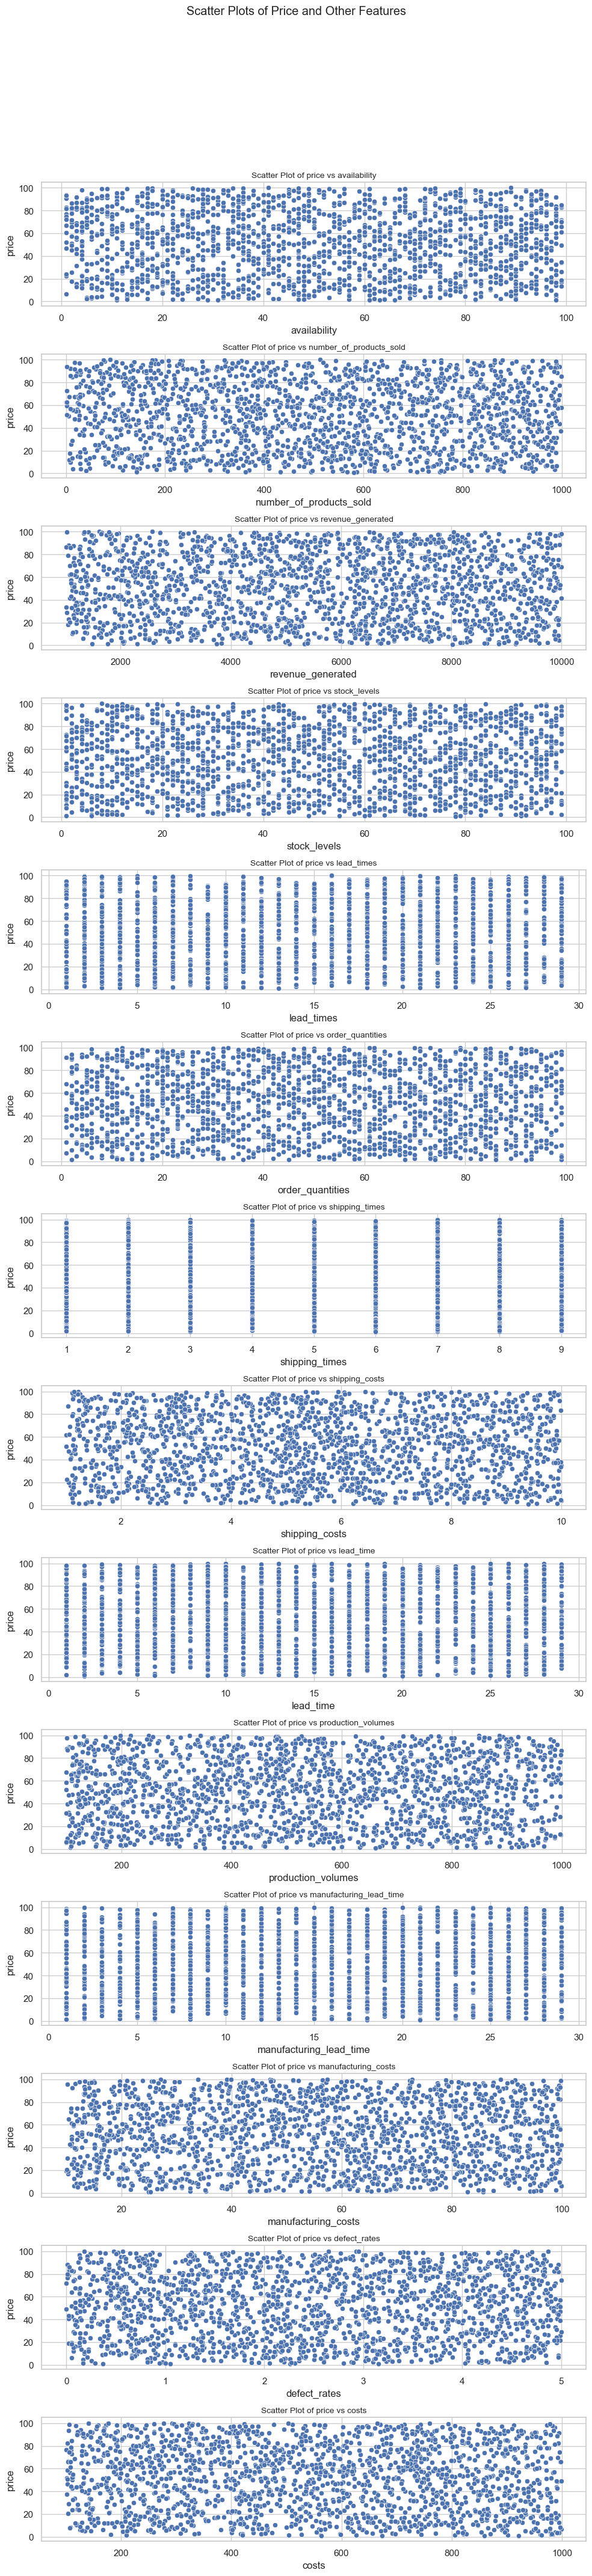

In [69]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

target = 'price'
variables = numeric_features.columns.drop(target)

fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, len(variables) * 3))

for i, var in enumerate(variables):
    sns.scatterplot(x=numeric_features[var], y=numeric_features[target], ax=axes[i])
    axes[i].set_title(f'Scatter Plot of {target} vs {var}', fontsize=10)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(target)

plt.tight_layout()
fig.suptitle('Scatter Plots of Price and Other Features', y=1.02)
plt.subplots_adjust(top=0.95)
plt.show()


---

**Correlation Matrix**

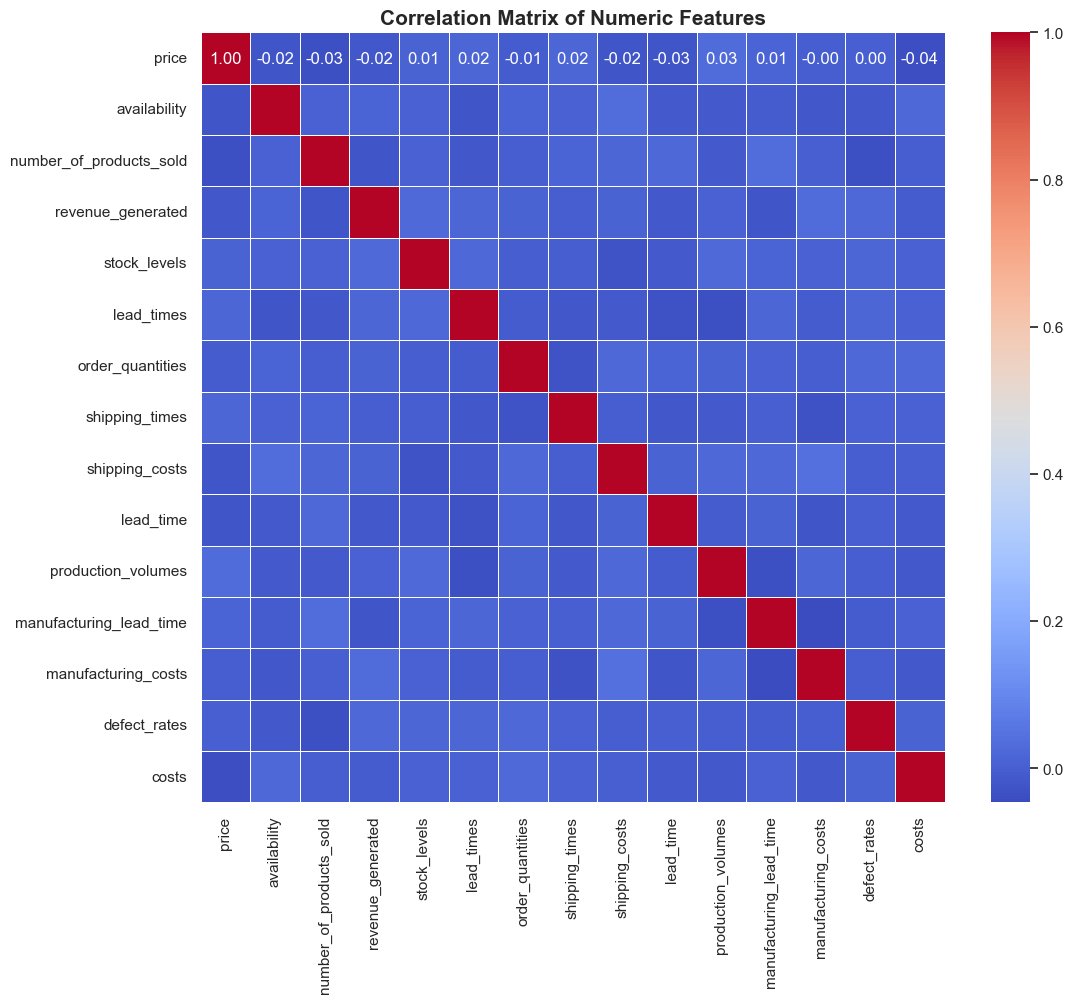

In [70]:
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

heatmap.set_title('Correlation Matrix of Numeric Features', fontsize=15, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

- Price has a low correlation with all other variables, indicating that price changes do not significantly affect other features or vice versa. (No strong linear regression)
- Availability ,Lead times ,Shipping timesshows very low correlation with other features, suggesting that the availability of products is relatively independent of other features.
- The only notable correlation is between the number of products sold and revenue generated (r=0.33), which aligns with expectations as sales volume typically drives revenue.

---

**Multicollinearity**

In [71]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

X = add_constant(numeric_features)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature        VIF
0                     const  57.231044
1                     price   1.006941
2              availability   1.003830
3   number_of_products_sold   1.005722
4         revenue_generated   1.004034
5              stock_levels   1.003248
6                lead_times   1.005127
7          order_quantities   1.002925
8            shipping_times   1.003270
9            shipping_costs   1.006241
10                lead_time   1.003909
11       production_volumes   1.005481
12  manufacturing_lead_time   1.006367
13      manufacturing_costs   1.007301
14             defect_rates   1.003215
15                    costs   1.003525


- All features have VIF values close to 1, indicating that there is very low multicollinearity among them.